In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from sklearn.utils import shuffle
import cufflinks as cf
import plotly
import plotly.express as px
import seaborn as sns

import re
import string 
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.util import ngrams

import spacy
import unidecode

from IPython.core.display import HTML

from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pandas import DataFrame
from plotly.offline import iplot
from collections import OrderedDict 
from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [29]:
# utile si prompt n'arrive pas à accéder aux certif SSL 

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
#     # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
#     # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [31]:
import certifi
certifi.where()

'C:\\Users\\J1055251\\Anaconda3\\lib\\site-packages\\certifi\\cacert.pem'

In [1]:
#Extraction du fichier zip

from zipfile import ZipFile

file_name='archive.zip'

with ZipFile(file_name, 'r') as zip:
    zip.printdir()
    zip.extractall()

File Name                                             Modified             Size
news.csv                                       2019-10-31 21:46:14     30696129


In [13]:
#Importation du fichier csv avec le dataset
df = pd.read_csv("news.csv", sep=',')
df.head()

Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL

# Nettoyage des données

In [14]:
#on retire la colonne avec l'index 
df.drop(columns=df.columns[0], 
        axis=1, 
        inplace=True)

In [16]:
#Création d'une nouvelle colonne : 1 pour les faux articles et 0 pour les vrais
df.loc[df.label=="FAKE",'fake']= 1
df.loc[df.label=="REAL",'fake']= 0
#df=df.drop('label',axis=1)

df.head()

title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text label  fake  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE   1.0  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE   1.0  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL   0.0  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE   1.0  
4  It's primary day in New York and front-runners...  REAL   0.0

In [17]:
# Dimension du data frame
df.shape

(6335, 4)

In [18]:
# Recherche des valeurs manquantes
df.isnull().sum()

title    0
text     0
label    0
fake     0
dtype: int64

In [8]:
#df = df.fillna('')

In [9]:
#df.isnull().sum()

title    0
text     0
fake     0
dtype: int64

In [10]:
#df['text'] = df['title']

In [19]:
# Mélange du data frame
df=shuffle(df).reset_index(drop=True)

# Tokenization et stemming

In [22]:
def preprocess_data(doc_set, expressions=None):
    
    def stemming(words, st):
        new = []
        stemmed = st(words)
        for token in stemmed:
            new.append(token.lemma_)
        return ' '.join(new)
    # Création d'un pattern pour tokenizer les articles
    tokenizer = RegexpTokenizer(r'\w+')
    # Liste de stop words en anglais
    fr_stop = set(stopwords.words('english'))
    #fr_stop.discard("pas")
    # Importation du module de spacy permettant le stemming (racinisation des mots)
    stemmer = spacy.load('en_core_web_sm')
    # liste avec les éléments tokenizé
    texts = []

    for i in doc_set:
        if pd.isna(i):
            next

        raw = i.lower()
        raw = unidecode.unidecode(raw)
        latin = ''
        for c in raw:
            latin += c if len(c.encode(encoding='utf_8'))==1 else ''

        if expressions != None:
            for key in expressions:
                latin = latin.replace(key, expressions[key])

        tokens = tokenizer.tokenize(latin)
        # on retire les stop words
        stopped_tokens = [i for i in tokens if (not (i in fr_stop)) and (len(i) > 2)]
 
        stemmed_tokens = stemming(" ".join(stopped_tokens), stemmer).split(" ")
        texts.append(stemmed_tokens)

    return texts

In [25]:
# Application de la fonction sur les titres et le texte
title = df['title']
text = df['text']

preprocessed_title = preprocess_data(title)
preprocessed_title

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [12]:
# On retire les ponctuations ?

#Note : on pourrait pas les utiliser ?

def remove_punct(_str):
  _str = re.sub('['+string.punctuation+']', ' ', _str)
  _str = re.sub('[\r]', ' ', _str)
  _str = re.sub('[\n]', ' ', _str)
  return _str

df['text'] = df['text'].apply(remove_punct)

In [13]:
# On exclue les stopwords en anglais 

stop_words=stopwords.words('english')
df["text_without_stopwords"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [14]:
# On transformer notre texte en plusieurs mots séparés par des espaces.
df['tokenized_text'] = df.apply(lambda row: word_tokenize(row['text_without_stopwords']), axis=1)

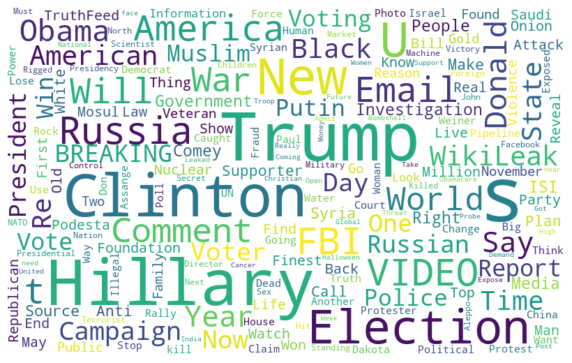

In [15]:
df_fake = df[df["fake"] == 1]
collect_words = ' '.join([txt for txt in df_fake.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False,background_color="white").generate(collect_words)
plot.figure(figsize=(10,7))
plot.imshow(wordcloud, interpolation='bilinear')
plot.axis("off")
plot.show()

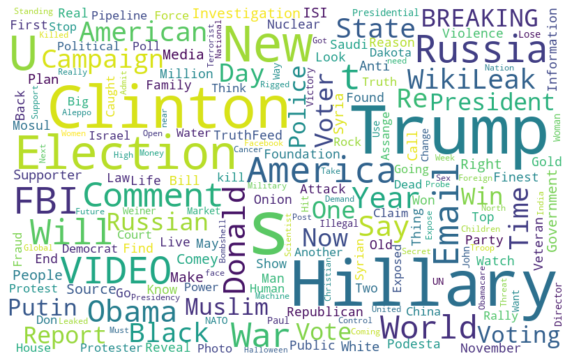

In [16]:
df_true = df[df["fake"] == 0]
collect_words = ' '.join([txt for txt in df_fake.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False,background_color="white").generate(collect_words)
plot.figure(figsize=(10,7))
plot.imshow(wordcloud, interpolation='bilinear')
plot.axis("off")
plot.show()

In [17]:
x = df["text_without_stopwords"]
y = df["fake"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

## XG BOOST

In [27]:
XGB = GradientBoostingClassifier(random_state=0)
XGB.fit(xv_train, y_train)
pred_rfc = XGB.predict(xv_test)

XGB.score(xv_test, y_test)

print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

         0.0       0.82      0.67      0.74       802
         1.0       0.72      0.85      0.78       782

    accuracy                           0.76      1584
   macro avg       0.77      0.76      0.76      1584
weighted avg       0.77      0.76      0.76      1584

[[540 262]
 [121 661]]


In [29]:
param_grid = { 
    'n_estimators': [100 ,200, 500],
    'learning_rate': [0.01 ,0.1, 0.5],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae']
}

In [ ]:
CV_XGB = GridSearchCV(estimator=XGB, param_grid=param_grid,cv=10)
grid_resultat_XGB = CV_XGB.fit(xv_train, y_train)
grid_resultat_XGB.best_params_

C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\rmani\Anaconda3\lib\sit

C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\rmani\Anaconda3\lib\sit

C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\rmani\Anaconda3\lib\sit

C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "C:\Users\rmani\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\rmani\Anaconda3\lib\sit

## Arbre de decision

In [20]:
DTC = DecisionTreeClassifier(random_state=0)
DTC.fit(xv_train, y_train)
pred_rfc = DTC.predict(xv_test)

DTC.score(xv_test, y_test)

print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77       802
         1.0       0.77      0.74      0.75       782

    accuracy                           0.76      1584
   macro avg       0.76      0.76      0.76      1584
weighted avg       0.76      0.76      0.76      1584

[[631 171]
 [205 577]]


In [ ]:
param_grid = { 
    'min_samples_split' : np.arrange[2,10,2],
    'max_features': [None,'auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random'],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_XGB = GridSearchCV(estimator=XGB, param_grid=param_grid,cv=10)
grid_resultat_XGB = CV_XGB.fit(xv_train, y_train)
grid_resultat_XGB.best_params_

## Random Forest

In [18]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)
pred_rfc = RFC.predict(xv_test)

RFC.score(xv_test, y_test)

print(classification_report(y_test, pred_rfc))
print(confusion_matrix(y_test, pred_rfc))

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.80       802
         1.0       0.78      0.83      0.80       782

    accuracy                           0.80      1584
   macro avg       0.80      0.80      0.80      1584
weighted avg       0.80      0.80      0.80      1584

[[621 181]
 [134 648]]


In [19]:
rfc=RandomForestClassifier(random_state=42)

In [20]:
param_grid = { 
    'n_estimators': [100 ,200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

In [21]:
CV_rtf = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=10)
grid_resultat_rtf = CV_rtf.fit(xv_train, y_train)

In [22]:
grid_resultat_rtf.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 500}

In [23]:
rtf = grid_resultat_rtf.best_estimator_
rtf.score(xv_test, y_test)
y_pred = rtf.predict(xv_test)

In [24]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[661 130]
 [131 662]]
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       791
         1.0       0.84      0.83      0.84       793

    accuracy                           0.84      1584
   macro avg       0.84      0.84      0.84      1584
weighted avg       0.84      0.84      0.84      1584

